In [107]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

In [108]:
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (124, 13) Test: (54, 13)


In [110]:
knn_orig = KNeighborsClassifier(n_neighbors=3)
knn_orig.fit(X_train, y_train)
y_pred_orig = knn_orig.predict(X_test)
acc_orig = accuracy_score(y_test, y_pred_orig)

print("KNN (original features) accuracy =", acc_orig*100)

KNN (original features) accuracy = 74.07407407407408


In [111]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn_pca = KNeighborsClassifier(n_neighbors=3)
knn_pca.fit(X_train_pca, y_train)
y_pred_pca = knn_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

print("KNN (PCA=2 features) accuracy =", acc_pca*100)

KNN (PCA=2 features) accuracy = 74.07407407407408


In [112]:
alcohol_index = feature_names.index("alcohol")

def rule_based_predict(X):
    alc = X[:, alcohol_index]
    preds = np.zeros_like(alc, dtype=int)
    preds[alc <= 12] = 0
    preds[(alc > 12) & (alc <= 13)] = 1
    preds[alc > 13] = 2
    return preds

y_pred_rule = rule_based_predict(X_test)
acc_rule = accuracy_score(y_test, y_pred_rule)
print("Rule-Based accuracy =", acc_rule*100)

Rule-Based accuracy = 46.2962962962963


In [113]:
metrics = ["euclidean", "manhattan", "cosine", "mahalanobis", "chebyshev"]
results = []

cov = np.cov(X_train_pca.T)
VI = np.linalg.inv(cov)

for metric in metrics:
    if metric == "mahalanobis":
        knn = KNeighborsClassifier(n_neighbors=3, metric=metric, metric_params={'VI': VI})
    else:
        knn = KNeighborsClassifier(n_neighbors=3, metric=metric)

    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    results.append((metric, accuracy_score(y_test, y_pred)))

print("Distance Metric Results:")
for m, a in results:
    print(m, ":", a*100)

Distance Metric Results:
euclidean : 74.07407407407408
manhattan : 74.07407407407408
cosine : 66.66666666666666
mahalanobis : 74.07407407407408
chebyshev : 74.07407407407408


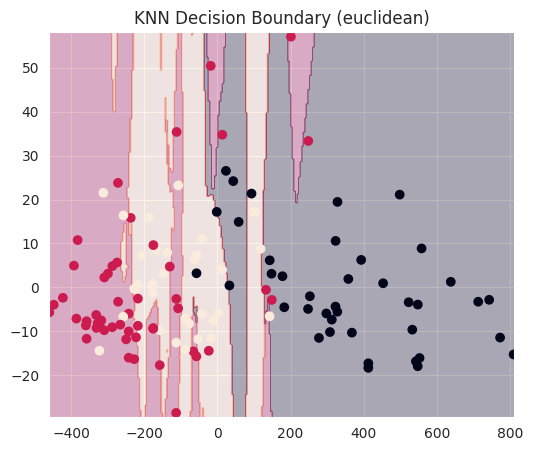

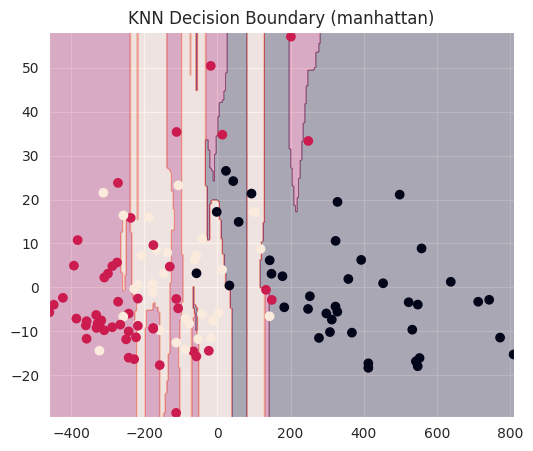

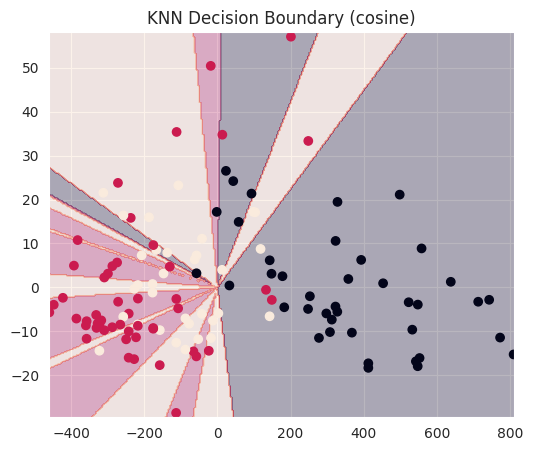

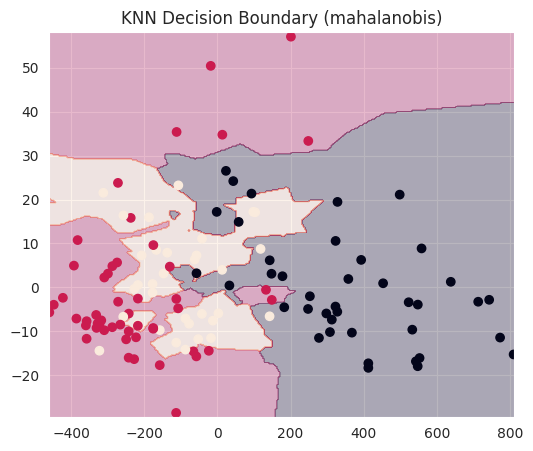

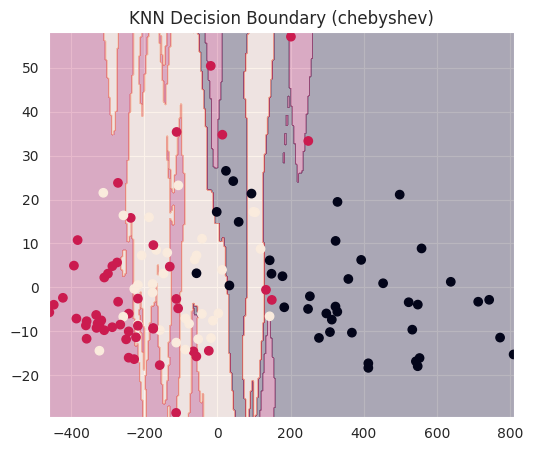

In [114]:
def plot_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title(title)
    plt.show()

for metric in metrics:
    if metric == "mahalanobis":
        clf = KNeighborsClassifier(n_neighbors=3, metric=metric, metric_params={'VI': VI})
    else:
        clf = KNeighborsClassifier(n_neighbors=3, metric=metric)
    clf.fit(X_train_pca, y_train)

    plot_boundary(clf, X_train_pca, y_train, f"KNN Decision Boundary ({metric})")

Soft Encoding + Linear Regression accuracy = 59.25925925925925


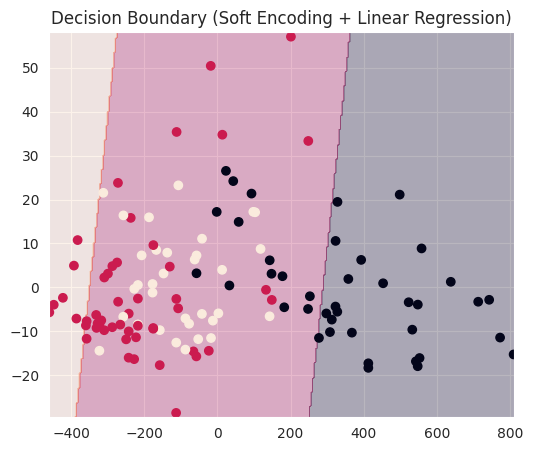

In [115]:
soft_map = {0:0.0, 1:0.5, 2:1.0}
y_train_soft = np.vectorize(soft_map.get)(y_train)

reg = LinearRegression()
reg.fit(X_train_pca, y_train_soft)

y_pred_cont = reg.predict(X_test_pca)

soft_vals = np.array([0.0, 0.5, 1.0])

def cont_to_class(preds):
    idx = np.abs(preds[:, None] - soft_vals).argmin(axis=1)
    return idx  # 0,1,2

y_pred_reg = cont_to_class(y_pred_cont)
acc_reg = accuracy_score(y_test, y_pred_reg)

print("Soft Encoding + Linear Regression accuracy =", acc_reg*100)

xx, yy = np.meshgrid(
    np.linspace(X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1, 300),
    np.linspace(X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_pred_cont = reg.predict(grid)
grid_pred_cls = cont_to_class(grid_pred_cont).reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, grid_pred_cls, alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)
plt.title("Decision Boundary (Soft Encoding + Linear Regression)")
plt.show()

In [116]:
print("KNN (original features):", acc_orig*100)
print("KNN (PCA=2):", acc_pca*100)
print("Rule-based:", acc_rule*100)
print("Soft Encoding Regression:", acc_reg*100)

KNN (original features): 74.07407407407408
KNN (PCA=2): 74.07407407407408
Rule-based: 46.2962962962963
Soft Encoding Regression: 59.25925925925925
